# DATA

In [1]:
import numpy as np
import pandas as pd
import sklearn
import os
import pickle
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy.stats import norm


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  
tf.random.set_seed(1234)

In [2]:
data = pd.read_csv('data/final_data.csv')
data.head()

,r,sigma,T,s0,k,t,asset,call,asset_greater_call,scaled_call,scaled_asset,tau,moneyness,d1,d2,delta,gamma,theta,vega,rho
0,0.05,0.05,0.1,10.0,10.0,0.0,10.000000,0.090978,True,0.009098,1.0,0.10,1.000000,0.324133,0.308322,0.627082,2.394010,-0.608243,1.197005,0.617984
1,0.05,0.05,0.1,10.0,10.0,1.0,9.977024,0.071240,True,0.007124,1.0,0.09,0.997702,0.154153,0.139153,0.561255,2.634254,-0.604191,1.179973,0.497558
2,0.05,0.05,0.1,10.0,10.0,2.0,9.979236,0.066344,True,0.006634,1.0,0.08,0.997924,0.142939,0.128797,0.556831,2.798086,-0.622830,1.114591,0.439232
3,0.05,0.05,0.1,10.0,10.0,3.0,10.085137,0.133263,True,0.013326,1.0,0.07,1.008514,0.912040,0.898811,0.819126,1.972797,-0.657203,0.702286,0.568942
4,0.05,0.05,0.1,10.0,10.0,4.0,9.964273,0.045868,True,0.004587,1.0,0.06,0.996427,-0.041160,-0.053407,0.483584,3.266261,-0.644005,0.972889,0.286362


In [3]:
scaler = StandardScaler()
X = data[['r','sigma','tau','k','asset']]
y = data['call']
#X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

# NEURAL NET MODEL

In [4]:
from keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.initializers import RandomUniform, GlorotUniform, HeUniform
from keras.models import model_from_json
from keras import backend as K
import tensorflow_addons as tfa
from tensorflow import GradientTape

In [5]:
def create_model(activation, lr_0, batch_norm, dropout_rate, layer_number, neuron_number,\
                neuron_decrease, data_length, initializer):
    opt = Adam(learning_rate = lr_0)
    model = Sequential()
    model.add(Dense(neuron_number, input_shape=(5,), activation = activation, \
                    kernel_initializer=initializer , bias_initializer=initializer, name='Input_layer'))
    for i in range(layer_number):
        if batch_norm == True:
            model.add(BatchNormalization())         
        neuron_number = int(neuron_number/neuron_decrease)
        model.add(Dense(neuron_number, activation = activation, name='Hidden_layer_'+str(i+1)))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    if dropout_rate != 0.0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, name='Final_1D_output', activation = activation))
    model.compile(optimizer=opt,loss='mean_squared_error',\
                  metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))],\
                 run_eagerly=True)
    print(model.summary())
    return model

def callback_list(patience):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    return early_stop

In [6]:
patience_f = 10
callbacks = callback_list(patience=patience_f)

# FINAL MODEL

In [7]:
# load json and create model
json_file_hyper = open('results/200epochs_results_greeks/model_200_epochs_greeks.json', 'r')
model_hyper = json_file_hyper.read()
json_file_hyper.close()
final_model = model_from_json(model_hyper)
# load weights into new model
final_model.load_weights("results/200epochs_results_greeks/model_200_epochs_greeks.h5")
print("Loaded model from disk")

Metal device set to: Apple M1 Pro
Loaded model from disk


In [8]:
final_hist = pd.read_csv('results/200epochs_results_greeks/train_hist_200_greeks.csv')
final_hist

,loss,r_square,val_loss,val_r_square
0,2.927485,0.937921,5.487534,0.885339
1,0.485869,0.989697,1.167987,0.975595
2,0.296514,0.993712,0.309233,0.993539
3,0.219167,0.995352,0.387079,0.991912
4,0.176699,0.996253,0.043382,0.999094
5,0.170760,0.996379,0.576207,0.987960
6,0.141923,0.996990,0.049927,0.998957
7,0.151927,0.996778,0.055957,0.998831
8,0.116931,0.997520,0.101697,0.997875
9,0.116366,0.997532,0.992037,0.979272


In [9]:
# HYPERPARAMETER TUNING
a_file = open("results/grid_results_greeks/search_params_extra_greeks.pkl", "rb")
output = pickle.load(a_file)
print(output)
a_file.close()

{'activation': 'relu', 'batch_norm': True, 'batch_size': 2048, 'data_length': 1000000, 'dropout_rate': 0.0, 'initializer': <keras.initializers.initializers_v2.RandomUniform object at 0x28ed513a0>, 'layer_number': 3, 'lr_0': 0.001, 'neuron_decrease': 2, 'neuron_number': 512}


In [10]:
final_model_arch = create_model(activation = output['activation'], lr_0 = output['lr_0'], \
                                 batch_norm = output['batch_norm'], dropout_rate = output['dropout_rate'], \
                                 layer_number = output['layer_number'], neuron_number = output['neuron_number'], \
                                    data_length = output['data_length'], neuron_decrease = output['neuron_decrease'],\
                                 initializer = output['initializer'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Dense)         (None, 512)               3072      
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 Hidden_layer_1 (Dense)      (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 Hidden_layer_2 (Dense)      (None, 128)               32896     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              5

In [11]:
def plot_loss(loss,val_loss,name):    
    plt.figure(figsize = (14,10))
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title(name+' history of train and validation data',fontsize='x-large')
    plt.ylabel(name,fontsize='x-large')
    plt.xlabel('Epoch',fontsize='x-large')
    plt.ticklabel_format( style='sci')
    plt.legend(['Train', 'Validation'], loc='upper right',fontsize='x-large')
    plt.show()

def plot_metr(metr,val_metr,name):
    plt.figure(figsize = (14,10))
    plt.plot(metr)
    plt.plot(val_metr)
    plt.title(name+' history of train and validation data',fontsize='x-large')
    plt.ylabel(str(name),fontsize='x-large')
    plt.xlabel('Epoch',fontsize='x-large')
    plt.ticklabel_format(useOffset=False)
    plt.legend(['Train', 'Validation'], loc='lower right',fontsize='x-large')
    plt.show() 

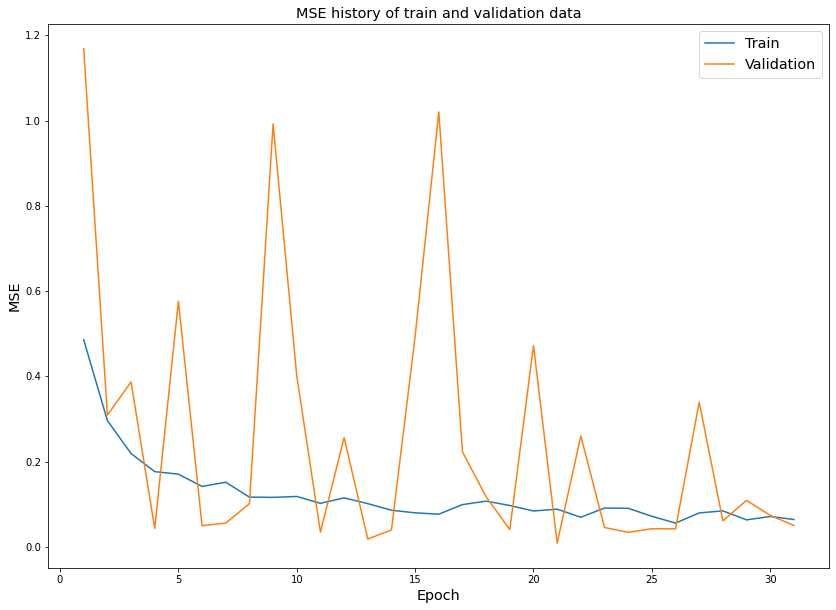

In [12]:
plot_loss(final_hist['loss'][1:], final_hist['val_loss'][1:], 'MSE')

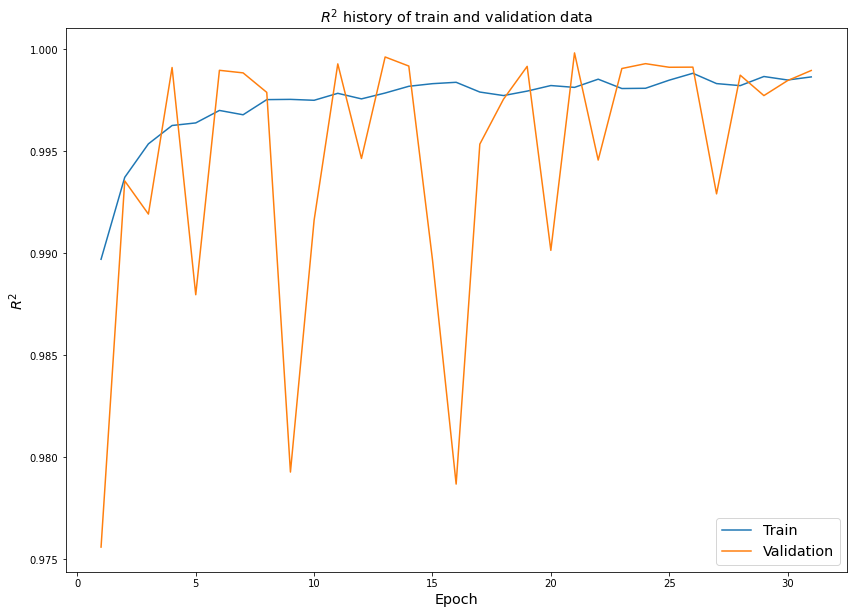

In [13]:
plot_metr(final_hist['r_square'][1:], \
          final_hist['val_r_square'][1:], '$R^2$')

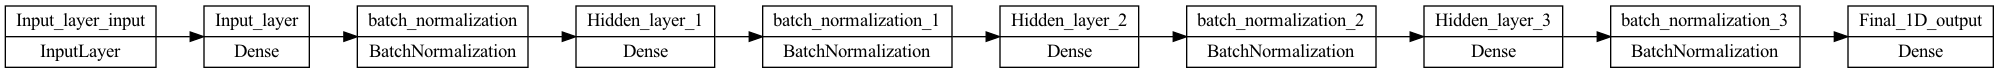

In [14]:
plot_model(final_model_arch, to_file='images/final_models/model_final_greeks.png',
           #show_shapes=True, 
           rankdir='LR')

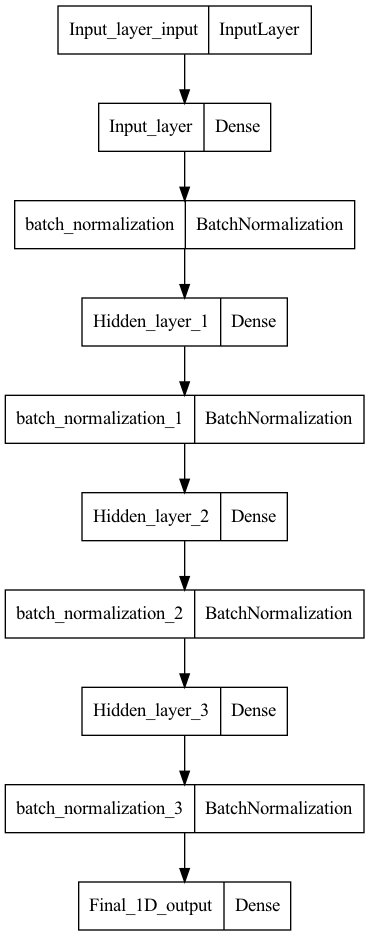

In [15]:
plot_model(final_model_arch, to_file='images/final_models/model_v_final_greeks.png')

## Evaluation

In [16]:
final_model.compile(optimizer=Adam(learning_rate = output['lr_0']),loss='mean_squared_error',\
                  metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))],\
                 run_eagerly=True)

In [17]:
final_model.evaluate(
    x=X_test,
    y=y_test,
    batch_size=output['batch_size'],
    callbacks=callbacks,
    return_dict=True
)

2022-05-28 10:00:11.585082: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


98/98 [==============================] - 2s 13ms/step - loss: 0.0106 - r_square: 0.9998


{'loss': 0.010627958923578262, 'r_square': 0.9997866749763489}

In [18]:
start = datetime.now()
preds = final_model.predict(
    x=X_test,
    batch_size=output['batch_size'],
    callbacks=callbacks
)
end = datetime.now()
print("It takes ", (end-start).total_seconds(), "seconds to compute 200k call prices using the trained DNN.")

It takes  0.537246 seconds to compute 200k call prices using the trained DNN.


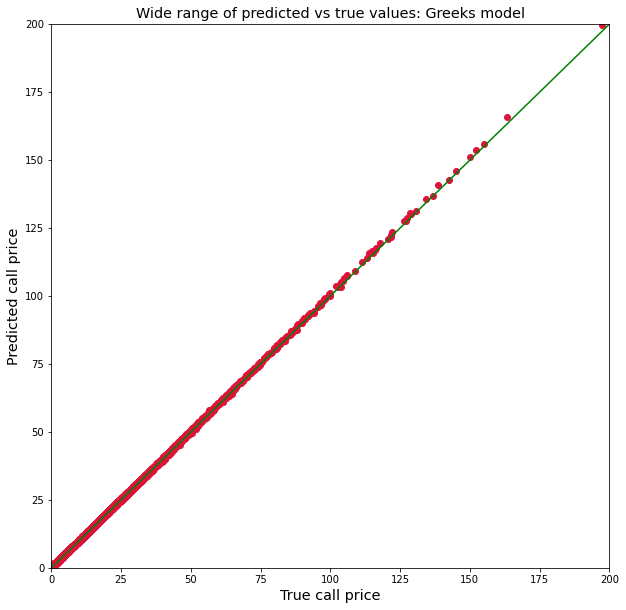

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(y_test), preds, c='crimson')
p1 = max(max(preds), max(np.array(y_test)))
p2 = min(min(preds), min(np.array(y_test)))
plt.plot([p1, p2], [p1, p2], 'g-')
plt.xlabel('True call price',fontsize='x-large')
plt.ylabel('Predicted call price',fontsize='x-large')
plt.title('Wide range of predicted vs true values: Greeks model',fontsize='x-large')
plt.xlim((0,200))
plt.ylim((0,200))
#plt.axis('equal')
plt.show()

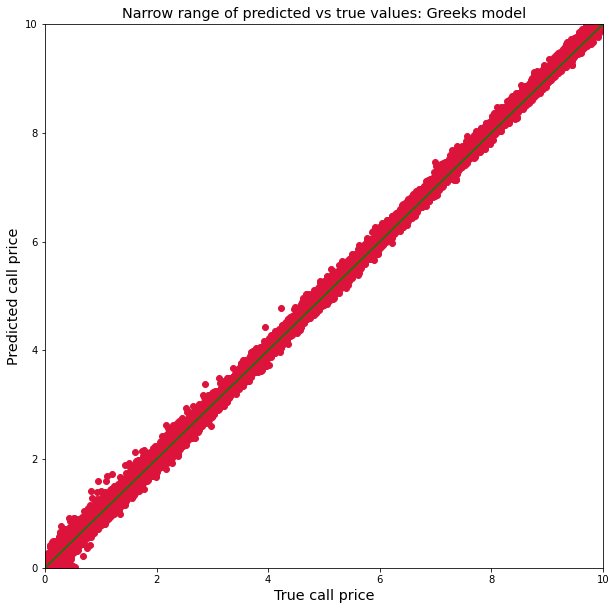

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(y_test), preds, c='crimson')
p1 = max(max(preds), max(np.array(y_test)))
p2 = min(min(preds), min(np.array(y_test)))
plt.plot([p1, p2], [p1, p2], 'g-')
plt.xlabel('True call price',fontsize='x-large')
plt.ylabel('Predicted call price',fontsize='x-large')
plt.title('Narrow range of predicted vs true values: Greeks model',fontsize='x-large')
plt.xlim((0,10))
plt.ylim((0,10))
#plt.axis('equal')
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

mape = mean_absolute_percentage_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print("{:.2e}".format(mape),"{:.2e}".format(mae))

1.66e-01 6.60e-02


In [23]:
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
print("{:.2e}".format(mse),"{:.2e}".format(np.sqrt(mse)),"{:.2e}".format(r2))

1.06e-02 1.03e-01 1.00e+00


## Greeks

In [24]:
start_2 = datetime.now()
inputs = tf.Variable(X, dtype = tf.float32)
with tf.GradientTape() as tape:
    pred = final_model(inputs)
grads = tape.gradient(pred,inputs)
end_2 = datetime.now()
print("It takes ", (end_2-start_2).total_seconds(), "seconds to compute 1M samples of the four Greeks using the trained DNN.")

It takes  0.151619 seconds to compute 1M samples of the four Greeks using the trained DNN.


In [24]:
grads_df = pd.DataFrame(grads, columns=['rho','vega','theta','nada','delta'])

In [25]:
grads_df

,rho,vega,theta,nada,delta
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
999995,1.269004,2.108502,4.366109,-0.104433,0.379362
999996,3.901888,-0.005999,9.585815,-0.461799,0.937582
999997,2.209988,2.035514,12.797746,-0.358109,0.904783
999998,1.793949,3.696510,15.156990,-0.449950,0.686495


In [26]:
greeks = data[['rho','vega','theta','gamma','delta']]
greeks

,rho,vega,theta,gamma,delta
0,0.617984,1.197005,-0.608243,2.394010,0.627082
1,0.497558,1.179973,-0.604191,2.634254,0.561255
2,0.439232,1.114591,-0.622830,2.798086,0.556831
3,0.568942,0.702286,-0.657203,1.972797,0.819126
4,0.286362,0.972889,-0.644005,3.266261,0.483584
...,...,...,...,...,...
999995,1.354152,2.532108,-4.978391,0.065842,0.472216
999996,5.081178,0.437121,-12.586878,0.000426,0.995450
999997,2.583177,3.018228,-12.958923,0.030184,0.782453
999998,1.459509,2.792118,-13.563948,0.053610,0.631423


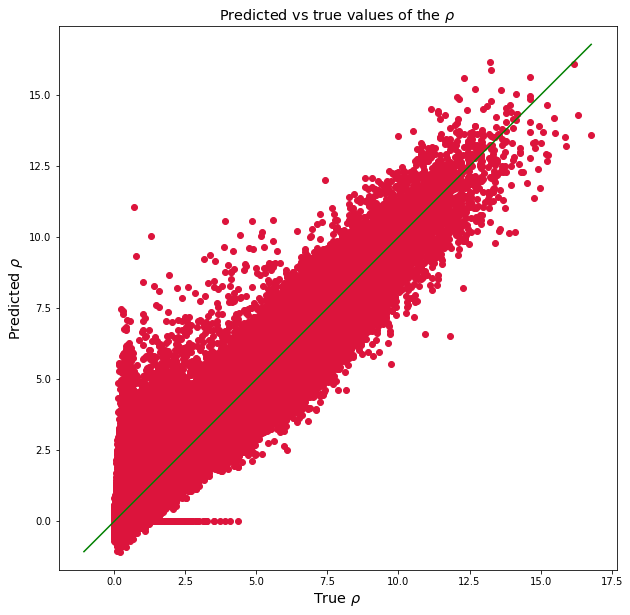

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(greeks['rho'], grads_df['rho'], c='crimson')
p1 = max(max(grads_df['rho']), max(greeks['rho']))
p2 = min(min(grads_df['rho']), min(greeks['rho']))
plt.plot([p1, p2], [p1, p2], 'g-')
plt.xlabel(r'True $\rho$',fontsize='x-large')
plt.ylabel(r'Predicted $\rho$',fontsize='x-large')
plt.title(r'Predicted vs true values of the $\rho$',fontsize='x-large')
#plt.xlim((0,17.5))
#plt.ylim((0,17.5))
plt.axis('equal')
plt.show()

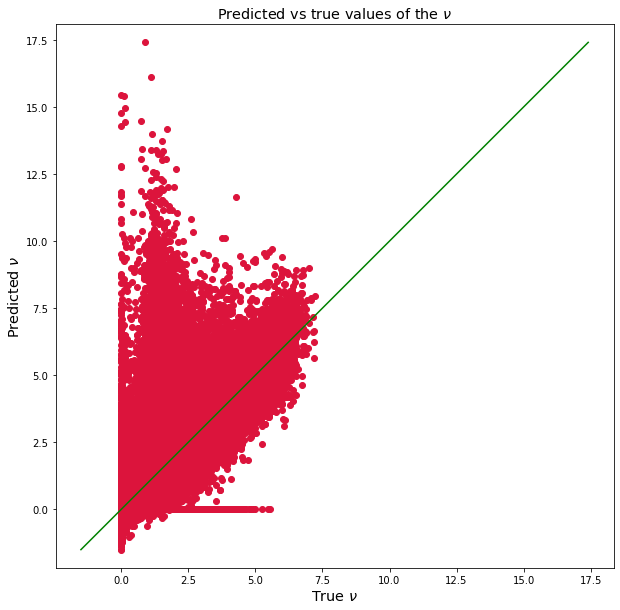

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(greeks['vega'], grads_df['vega'], c='crimson')
p1 = max(max(grads_df['vega']), max(greeks['vega']))
p2 = min(min(grads_df['vega']), min(greeks['vega']))
plt.plot([p1, p2], [p1, p2], 'g-')
plt.xlabel(r'True $\nu$',fontsize='x-large')
plt.ylabel(r'Predicted $\nu$',fontsize='x-large')
plt.title(r'Predicted vs true values of the $\nu$',fontsize='x-large')
#plt.xlim((0,17.5))
#plt.ylim((0,17.5))
plt.axis('equal')
plt.show()

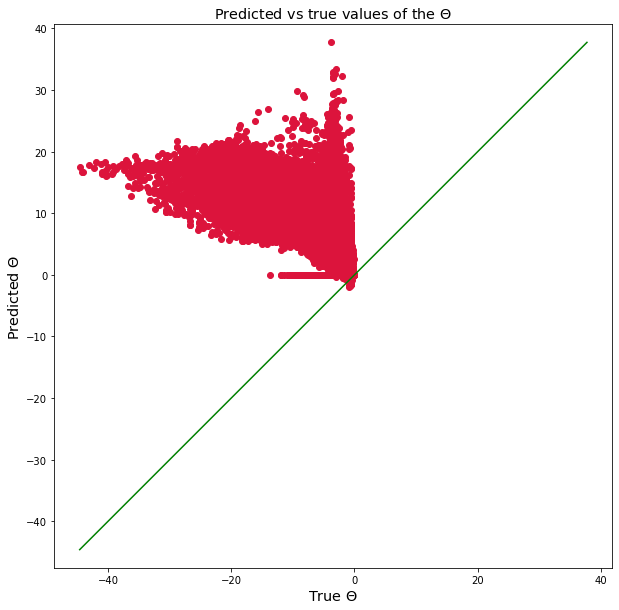

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(greeks['theta'], grads_df['theta'], c='crimson')
p1 = max(max(grads_df['theta']), max(greeks['theta']))
p2 = min(min(grads_df['theta']), min(greeks['theta']))
plt.plot([p1, p2], [p1, p2], 'g-')
plt.xlabel(r'True $\Theta$',fontsize='x-large')
plt.ylabel(r'Predicted $\Theta$',fontsize='x-large')
plt.title(r'Predicted vs true values of the $\Theta$',fontsize='x-large')
#plt.xlim((0,17.5))
#plt.ylim((0,17.5))
plt.axis('equal')
plt.show()

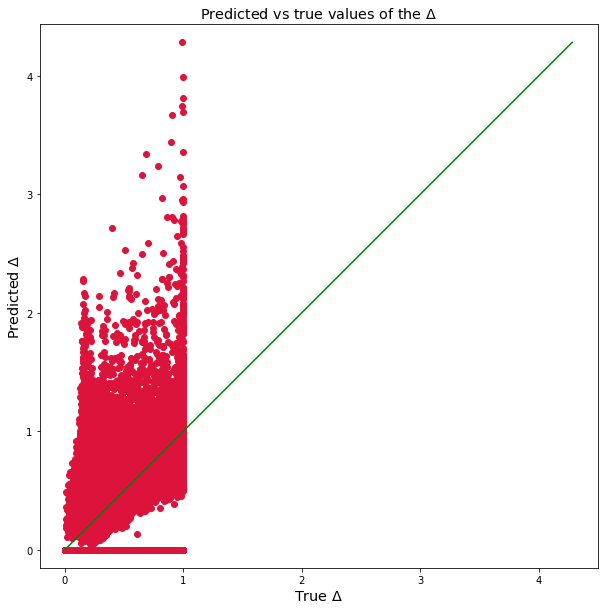

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(greeks['delta'], grads_df['delta'], c='crimson')
p1 = max(max(grads_df['delta']), max(greeks['delta']))
p2 = min(min(grads_df['delta']), min(greeks['delta']))
plt.plot([p1, p2], [p1, p2], 'g-')
plt.xlabel(r'True $\Delta$',fontsize='x-large')
plt.ylabel(r'Predicted $\Delta$',fontsize='x-large')
plt.title(r'Predicted vs true values of the $\Delta$',fontsize='x-large')
#plt.xlim((0,1))
#plt.ylim((0,1))
plt.axis('equal')
plt.show()

In [31]:
print(mean_squared_error(greeks['rho'],grads_df['rho']))
print(mean_squared_error(greeks['delta'],grads_df['delta']))
print(mean_squared_error(greeks['vega'],grads_df['vega']))
print(mean_squared_error(greeks['theta'],grads_df['theta']))

0.2206539224874107
0.009359419033617998
0.3231153203227098
173.53641948473174


In [32]:
print(np.sqrt(mean_squared_error(greeks['rho'],grads_df['rho'])))
print(np.sqrt(mean_squared_error(greeks['delta'],grads_df['delta'])))
print(np.sqrt(mean_squared_error(greeks['vega'],grads_df['vega'])))
print(np.sqrt(mean_squared_error(greeks['theta'],grads_df['theta'])))

0.46973814246600276
0.09674409043253235
0.5684323357469293
13.173322264513677


In [33]:
print(r2_score(greeks['rho'],grads_df['rho']))
print(r2_score(greeks['delta'],grads_df['delta']))
print(r2_score(greeks['vega'],grads_df['vega']))
print(r2_score(greeks['theta'],grads_df['theta']))

0.9438928566165854
0.92568041163735
0.7940380451415903
-11.020246824862177


In [34]:
print(mean_absolute_error(greeks['rho'],grads_df['rho']))
print(mean_absolute_error(greeks['delta'],grads_df['delta']))
print(mean_absolute_error(greeks['vega'],grads_df['vega']))
print(mean_absolute_error(greeks['theta'],grads_df['theta']))

0.3238040124366609
0.05960888701222729
0.3320052046409321
10.822546307386217


In [35]:
print(mean_absolute_percentage_error(greeks['rho'],grads_df['rho']))
print(mean_absolute_percentage_error(greeks['delta'],grads_df['delta']))
print(mean_absolute_percentage_error(greeks['vega'],grads_df['vega']))
print(mean_absolute_percentage_error(greeks['theta'],grads_df['theta']))

0.42339784217800563
0.23574444886400844
96569400088961.81
1.8911999872746394
